In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


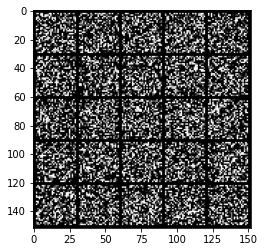

In [ ]:
#checking the show_tensor_images function
tensor = torch.randn((25,28,28))
show_tensor_images(tensor)

In [ ]:
def get_noise(n_samples,z_dim):
  '''
  Function to get random noise vector.
  creates a tensor of shape(batch,Z-dim) filled with random numbers from the normal distribution.
  Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
  ''' 

  return torch.randn(n_samples,z_dim, device=device)

In [ ]:
def get_generator_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
  '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)

        ConvTranspose2d---> Generally for upsampling
  '''
  if not final_layer:
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
        
    )
  else: 
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.Tanh()
    )

In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim=10, im_chan=1, hidden_dim=64):
    super().__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        get_generator_block(z_dim, hidden_dim * 4),
        get_generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        get_generator_block(hidden_dim * 2, hidden_dim),
        get_generator_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
    )

  def unsqueeze_noise(self, noise):
    '''
    Given a noise tensor,returns a copy of that noise with width and height = 1 and channels = z_dim.
    Parameters:
        noise: a noise tensor with dimensions (n_samples, z_dim)
    '''
    return noise.view(len(noise), self.z_dim, 1, 1)
  
  def forward(self, noise):
    
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

In [ ]:
def get_critic_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
  '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
  '''

  if not final_layer:
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.LeakyReLU(0.2)
    )
  else: 
    return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size, stride)
    )

In [ ]:
class Critic(nn.Module):
  def __init__(self,im_chan=1, hidden_dim=16,batch_size = 32):
    super().__init__()
    self.batch_size = batch_size
    self.disc = nn.Sequential(
        get_critic_block(im_chan, hidden_dim),
        get_critic_block(hidden_dim, hidden_dim * 2),
        get_critic_block(hidden_dim * 2, 1, final_layer=True),
    )

  def forward(self,image):
    return self.disc(image).view(self.batch_size, -1)

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [ ]:
z_dim = 64
display_step = 500
batch_size = 32
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
n_epochs = 100
crit_repeats = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
critic = Critic().to(device) 
critic_opt = torch.optim.Adam(critic.parameters(), lr=lr, betas=(beta_1, beta_2))

In [ ]:
#Initializing Weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = critic.apply(weights_init)

In [ ]:
def gradient_penalty(gradient):
  '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
  gradient = gradient.view(len(gradient),-1)
  gradient_norm = gradient.norm(2, dim=1)
  penalty = torch.mean((gradient_norm-1)**2)

  return penalty

In [ ]:
def get_gradient(critic, real, fake, epsilon):
  '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
  '''
  interpolated_image = real * epsilon + (1 - epsilon) * fake
  score = critic(interpolated_image)

  gradient = torch.autograd.grad(inputs = interpolated_image,
                outputs = score, 
                grad_outputs=torch.ones_like(score), 
                create_graph=True,
                retain_graph=True,)[0]

  return gradient

In [ ]:
def get_generator_loss(prediction):
  '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
  '''
  return -1. * torch.mean(prediction)

In [ ]:
def get_critic_loss(fake_pred, real_pred, gp, c_lambda):
  '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
  '''
  return torch.mean(fake_pred) - torch.mean(real_pred) + gp * c_lambda

  0%|          | 0/1875 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


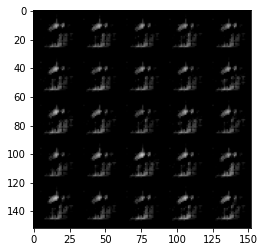

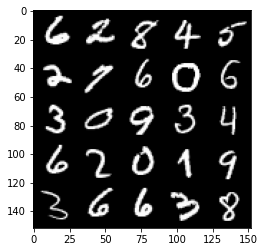

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


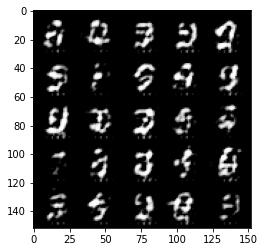

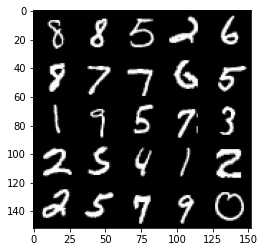

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


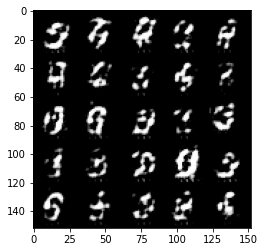

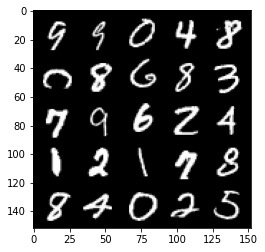

  0%|          | 0/1875 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


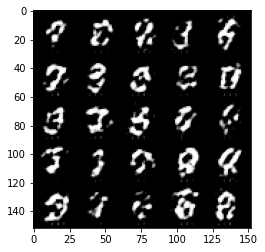

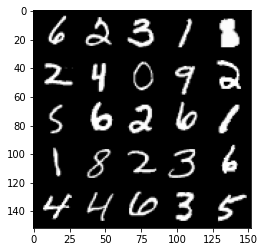

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


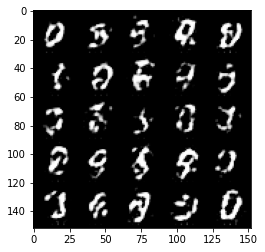

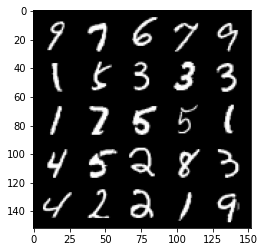

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


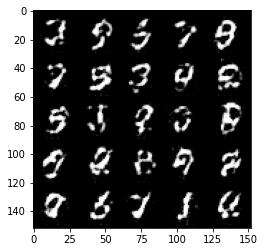

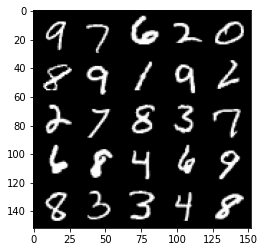

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


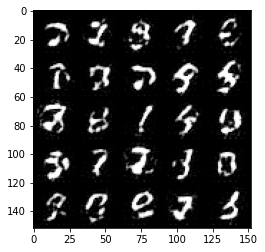

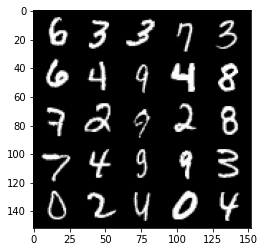

  0%|          | 0/1875 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


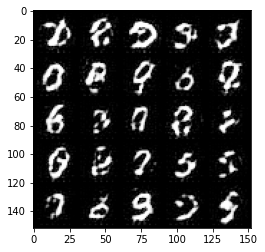

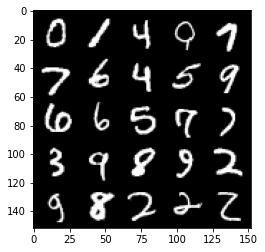

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


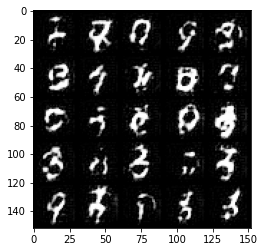

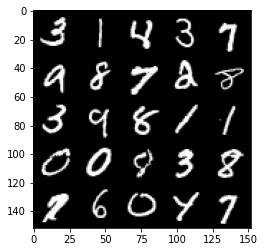

In [ ]:
generator_loss = []
critic_loss = []
cur_step = 0
c_lambda = 10

for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):

    mean_iteration_critic_loss = 0
    for _ in range(crit_repeats):
      critic_opt.zero_grad()
      fake_noise = get_noise(batch_size, z_dim)
      fake = gen(fake_noise)
      crit_fake_pred = critic(fake.detach())
      crit_real_pred = critic(real)

      epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
      gradient = get_gradient(critic, real, fake.detach(), epsilon)
      gp = gradient_penalty(gradient)
      crit_loss = get_critic_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

      mean_iteration_critic_loss += crit_loss.item() / crit_repeats
      crit_loss.backward(retain_graph=True)
      critic_opt.step()
    critic_loss = [mean_iteration_critic_loss]
    
    gen_opt.zero_grad()
    fake_noise_2 = get_noise(batch_size, z_dim)
    fake_2 = gen(fake_noise_2)
    crit_fake_pred = crit(fake_2)
    
    gen_loss = get_generator_loss(crit_fake_pred)
    gen_loss.backward()
    gen_opt.step()
    generator_loss += [gen_loss.item()]

    if cur_step % display_step == 0 and cur_step > 0:
      # print(f"Epoch{epoch}: Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
      fake_noise = get_noise(batch_size, z_dim)
      fake = gen(fake_noise)
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    
    cur_step += 1